### Colab Directory Setting

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [3]:
import os
os.chdir('/content/gdrive/My Drive')

In [3]:
#!unzip yoga_test.zip -d '/content/gdrive/My Drive/'
#!unzip yoga_train.zip -d '/content/gdrive/My Drive/'

#!pip install "torch==1.4" "torchvision==0.5.0"

In [2]:
import torch
import os
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from fastai.vision import *
from fastai.widgets import *

In [5]:
project_name='Course-Project-YogaPose-classifier'


## Data Preprocessing 

In [4]:

data_dir = '/content/gdrive/My Drive/yoga_dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', '.ipynb_checkpoints', 'valid', 'export.pkl']
['.DS_Store', 'warrior2', 'warrior1', 'trianglepose', 'downwarddog', 'mountain', 'plank', 'childs', 'tree', 'bridge', 'seatedforwardbend']


In [5]:
files = os.listdir(data_dir + "/train/" + classes[10])
file_count = len(files)
file_count

60

In [6]:
downwarddog_files = os.listdir(data_dir + "/train/downwarddog")
print('No. of training examples for Downward Dog:', len(downwarddog_files))
print(downwarddog_files[1:5])

No. of training examples for Downward Dog: 91
['File1.jpg', 'File11.jpg', 'File10.jpg', 'File12.jpg']



Traformations
*    Since images are of different sizes, we reseize it to a standard 256x256
*   Random cropping of image
*   Flipping doesn't make sense here because a flipped pose is not necessarily the same
*   We also normalize with a set of random mean ans variances incase of using a pre-trained model to perform transfer learning.





In [7]:
stats = ((0.7801192402839661, 0.7550891041755676, 0.7373213768005371), (0.32864445447921753, 0.3389450013637543, 0.35464248061180115))
transformations = T.Compose([
    T.Resize([256, 256]),
    T.ToTensor(),
    
    
])
#T.Normalize(*stats, inplace=True)
dataset = ImageFolder(data_dir+'/train', transform=transformations)


In [1]:
dataset[0]

NameError: ignored

In [8]:
print(dataset.classes)

['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


There are 10 different poses each class containing varying number of images in each.






Label:  bridge (0)


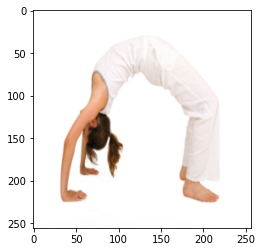

In [11]:
import matplotlib.pyplot as plt

def print_sample(img, label=0):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

print_sample(*dataset[10])

Label:  warrior2 (9)


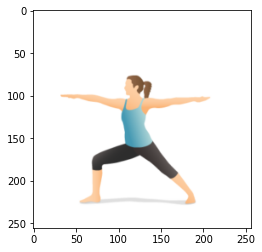

In [12]:
print_sample(*dataset[720])

In [13]:
len(dataset)

730

In [14]:
from torch.utils.data.dataloader import DataLoader

In [15]:
random_seed = 42
torch.manual_seed(random_seed);

In [10]:
val_size = 100
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True )
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

TypeError: ignored

In [ ]:
data_bunch = ImageDataBunch.from_folder(
    # Data director
    Path(data_dir), train='train', valid='valid',
    # Reserve 5 percent of our images for our validation set
    valid_pct=0.05,
    # Transforms to apply to the image to create variations on our training image
    ds_tfms=get_transforms(max_zoom=1.0), 
    # Dimension of image to process
    size=299,
    # Num workers to use
    num_workers=2
).normalize(
	# Use imagenet stats to normalize (to match what was pre-trained with)
	imagenet_stats
)

### One time execution
Calculating mean and variance for transform normalization


In [ ]:
'''mean = 0.0
for images, _ in train_dl:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(train_dl.dataset)

var = 0.0
for images, _ in train_dl:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(train_dl.dataset)*224*224))'''

In [ ]:
#mean.tolist(), std.tolist()

## A single batch of data

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

'''def imshow_grid(images, shape=[2, 8]):
    """Plot images in a grid of a given shape."""
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()'''
#imshow_grid(train_dl)

In [ ]:
data_bunch.show_batch()

## Model definition

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Simple CNN model 

In [ ]:
class YogaSimpleCnn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*256*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        #xb = xb.view(xb.size(0), -1)
        return torch.sigmoid(self.network(xb))

### Model 2 - Resnet 9 

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.conv5 = conv_block(512, 1024, pool=True)
        self.conv6 = conv_block(1024, 2048, pool=True)
        self.res3 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))

        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(2048*2*2, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

## facilitation GPU use and setting Torch - Cuda compatibility

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model1 = to_device(YogaSimpleCnn(), device)
model2 = to_device(ResNet9(3, 10), device)



### Model 3 - Fast AI - Squeezenet 

In [ ]:
learner = cnn_learner(data_bunch, models.squeezenet1_1, pretrained=True, metrics=accuracy)	


In [ ]:
"""for images, labels in train_dl:
    print('images.shape:', images.shape)
    #images = images.view(32, 3, 256, 256)
    #images = images.unsqueeze(dim = 0)
    out = model1(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break"""

In [ ]:
'''for images, labels in train_dl:
    print('images.shape:', images.shape)
    #images = images.view(32, 3, 256, 256)
    #images = images.unsqueeze(dim = 0)
    out = model2(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break'''

## Model Training 

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history1 = [evaluate(model1, val_dl)]

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [ ]:
history1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
model2 = to_device(ResNet9(3, 10), device)
model2

In [ ]:
history2 = [evaluate(model, val_dl)]
history2

In [ ]:
epochs = 45
max_lr = 1e-5
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [ ]:

# Start training
learner.fit_one_cycle(10)

# Unfreeze the model
learner.unfreeze()

# Train the entire model some more
learner.fit_one_cycle(10, max_lr=slice(1e-3, 1e-5))

# Reduce the learning rate and train some more
learner.fit_one_cycle(10, max_lr=slice(1e-4, 1e-6))


## Prediction and Loss evaluation

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plt.title('Accuracy vs. No. of epochs - Simple CNN');
plot_accuracies(history1)

plt.title('Accuracy vs. No. of epochs - Resnet 9');
plot_accuracies(history2)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
print('Model 1 Loss')
plot_losses(history1)
print('Model 2 loss')
plot_losses(history2)

In [ ]:
test_dataset = ImageFolder(data_dir+'/valid', transform=transformations)

test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size=2, num_workers=2, pin_memory=True), device)

In [ ]:
preds,y,losses = learner.get_preds(with_loss=True)
intr = ClassificationInterpretation(learner, preds, y, losses)
intr.plot_multi_top_losses()

In [ ]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

### Predict a batch of Test images

In [ ]:
from tqdm.notebook import tqdm
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        break;
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)

### Prediction for a single test image 

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = torch.sigmoid(preds.cpu().detach())
    label = [element.item() for element in prediction.flatten()]
    label = label.index(max(label))
    print("Prediction: ", prediction)
    print_sample(image, label)

In [ ]:
#test_dataset[100][0]
predict_single(test_dataset[100][0])

### Fast AI model prediction

In [ ]:
import imghdr
import os
from os import walk
#example_image = open_image(Path('/content/g'))
preds = dict(zip(classes, [0]*11))


def img(filename):
  image_type = imghdr.what(filename)
  if image_type:
    return True


# Make a prediction
for folder in os.listdir(data_dir +'/valid'):
  print("for class: " + folder)
  for (dirpath, dirnames, filenames) in walk(data_dir + '/valid/' + folder):
    for filename in filenames:
      fil = data_dir + '/valid/' + folder +'/'+ filename
      if img(fil):
        print(fil)      
        predicted_class, _, _ = learner.predict(fil)
        print("predicted val" + predicted_class)

print(preds)

# Export the model
learner.export()

In [ ]:
from google.colab import files
weights_fname = 'resnet-classifier.pth'
torch.save(model.state_dict(), weights_fname)

files.download(weights_fname)